In [1]:
import torch
import torch.nn as nn

### Conv1x1 & Conv3x3 Functions
- ResNet은 3x3 Conv & 1x1 Conv만을 사용(연산량 감소를 위한 Bottle Neck Layer)
    - 자주 사용하는 1x1, 3x3 filter conv. layer 함수 정의
    - Input의 Size를 유지하기 위해 kernel_size와 padding은 바뀌지 않음
    - Channel(filter의 수)이 2배로 늘어나는 구간마다 stride를 2로 증가시켜 Activation map의 size를 줄임

In [2]:
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

### Basic Block Module
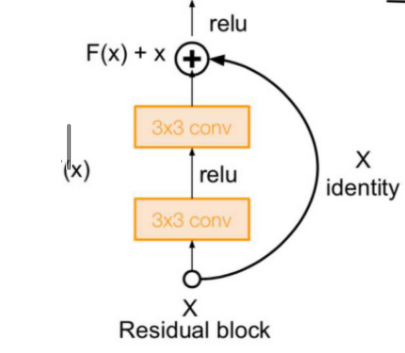

- 2개의 3x3 Covolution Layer와 Skip connection으로 구성

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.downsample = downsample    # Conv layer와 Skip connection의 output dimension이 다른 경우 맞춰주기 위함
        self.stride = stride
        
        self.conv1 = conv3x3(in_channels, out_channels, stride=self.stride)  # stride로 이미지 크기 조절할 경우
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = conv3x3(out_channels, out_channels, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.act = nn.ReLU()
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = out + identity  # (F(x) + x)
        out = self.act(out)
        
        return out  

### Bottleneck Block
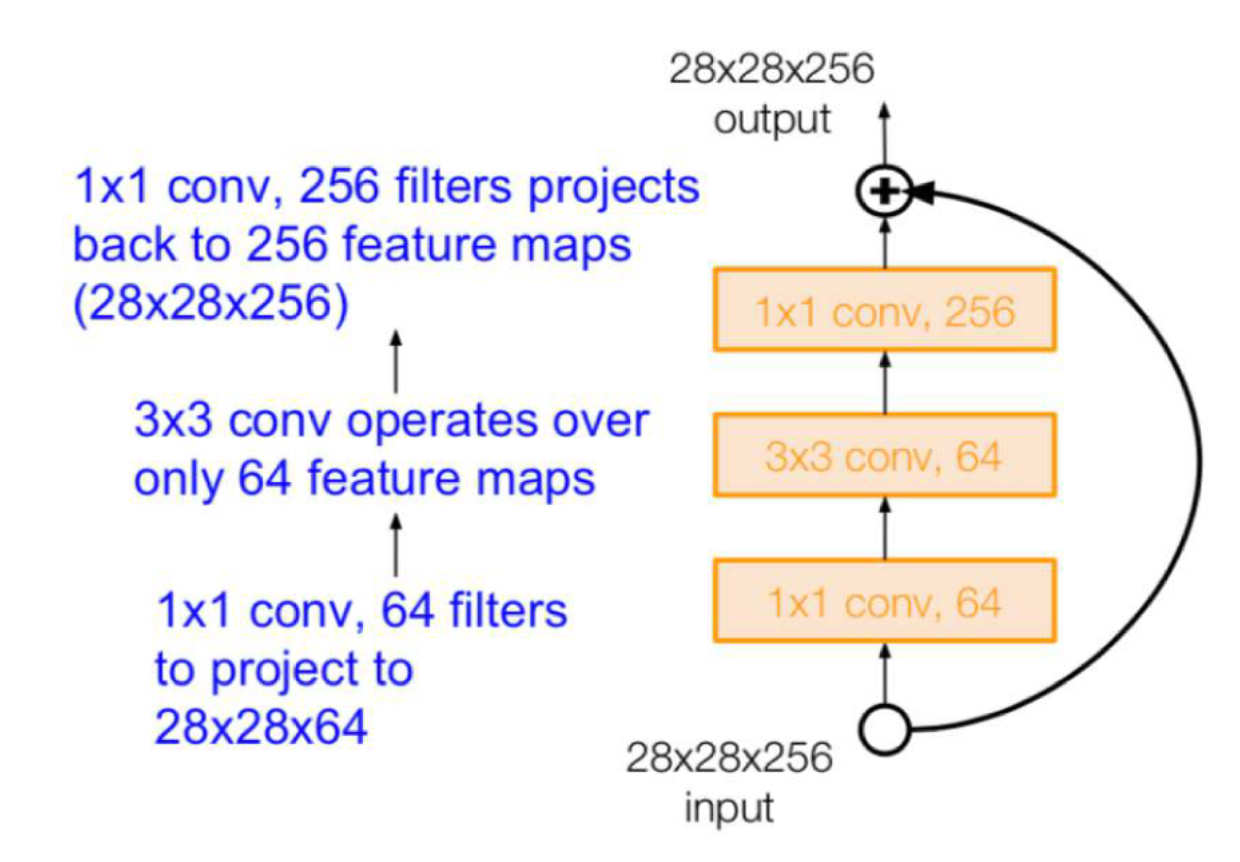
- 50개 이상의 layer를 가진 ResNet의 경우 연산량을 줄이기 위해 1x1 -> 3x3 -> 1x1
- Bottleneck Block의 경우, 연산 결과를 Basic Block의 output보다 채널 수를 4배로 늘림

In [4]:
class BottleNeck(nn.Module):
    expansion = 4  # 연산을 위해 줄인 channel depth를 마지막에 4배로 늘리기 위함
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleNeck, self).__init__()
        self.downsample = downsample
        self.stride = stride
        
        self.conv1 = conv1x1(in_channels, out_channels) # 연산량 줄이기 위해 channel 축소
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = conv3x3(out_channels, out_channels, stride = self.stride) 
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = conv1x1(out_channels, out_channels*self.expansion)  # channel *4배
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        out += identity
        
        return out

### ResNet Module

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_res=False):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 이미지 size 1/2
        self.bn1 = nn.BatchNorm2d(64)
        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 이미지 size 1/2
        
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride = 2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))   # 이미지 width, height 축 각각 average
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsmaple = None
        # 이미지의 크기가 변경되거나(각 layer_block의 시작), channel 수의 변화가 생겼다면 Identity의 size를 맞춰주기 위함
        if (stride != 1) or (self.in_channels != out_channels * block.expansion):
            downsmaple = nn.Sequential(
                            conv1x1(self.in_channels, out_channels * block.expansion, stride),
                            nn.BatchNorm2d(out_channels * block.expansion))
        
        layers = []
        # 첫번째 layer
        layers.append(block(self.in_channels, out_channels, stride, downsmaple))
        self.in_channels = out_channels * block.expansion
        
        # 나머지 layer
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
            
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)
        
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)   # batch size 외 flatten
        x = self.fc(x)
        return x

In [6]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

## Application

In [7]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import time

import argparse

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),    # image파일을 0 ~ 1사이의 값을 갖는 Tensor로 변환(0: 검은색)
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), )])  # 채널별로 0.5를 빼고(-0.5 ~ 0.5), 0.5로 나눔

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000,10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model_dict = {'ResNet18': ResNet18(),
            'ResNet34': ResNet34(),
            'ResNet50': ResNet50(),
            'ResNet101': ResNet101(),
            'ResNet152': ResNet152()}

In [10]:
from experiments import *

def experiment(partition, model_dict, args):
    m = model_dict[args.model_code]
    m = m.cuda()
    criterion = nn.CrossEntropyLoss()
    
    if args.optim == 'SGD':
        optimizer = optim.SGD(m.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(m.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(m.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('Invalid Optimizer! Try Again')
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(1, args.epochs+1):
        ts = time.time()
        m, train_loss, train_acc = train(m, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(m, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print('Epoch: {}/{}, Acc: {:2.2f}/{:2.2f}, Loss: {:2.2f}/{:2.2f}, Took:{:2.2f}sec'.format(
                    epoch, args.epochs, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(m, partition, args)
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['test_acc'] = test_acc
    return vars(args), result

In [57]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')

## model
args.model_code = 'ResNet18'
args.bn = True
args.dropout = 0.5

args.l2 = 0.0001
args.optim = 'Adam'
args.train_batch_size = 256
args.val_batch_size = 1024
args.lr = 0.001
args.epochs = 10

In [60]:
parameters, result = experiment(partition, model_dict, args)

Epoch: 1/10, Acc: 49.68/56.81, Loss: 1.49/1.25, Took:36.98sec
Epoch: 2/10, Acc: 63.58/57.80, Loss: 1.03/1.25, Took:31.47sec
Epoch: 3/10, Acc: 70.35/65.44, Loss: 0.84/1.00, Took:31.44sec
Epoch: 4/10, Acc: 74.39/69.61, Loss: 0.73/0.91, Took:32.96sec
Epoch: 5/10, Acc: 78.53/70.11, Loss: 0.61/0.90, Took:33.54sec
Epoch: 6/10, Acc: 81.46/71.42, Loss: 0.53/0.86, Took:32.35sec
Epoch: 7/10, Acc: 84.47/71.31, Loss: 0.44/0.90, Took:32.79sec
Epoch: 8/10, Acc: 87.03/71.78, Loss: 0.37/0.91, Took:33.14sec
Epoch: 9/10, Acc: 89.35/69.84, Loss: 0.30/1.03, Took:33.77sec
Epoch: 10/10, Acc: 91.00/71.25, Loss: 0.26/1.04, Took:33.12sec


In [61]:
result

{'train_losses': [1.4853783694042522,
  1.0250348338655606,
  0.837805890353622,
  0.726562356872923,
  0.6120154058477681,
  0.5309322297952737,
  0.44299953625460337,
  0.3728935097812847,
  0.3044668565130538,
  0.2571986589082487],
 'val_losses': [1.2508881568908692,
  1.2482956767082214,
  1.0027890622615814,
  0.9110031485557556,
  0.8977189302444458,
  0.8603473961353302,
  0.8963589668273926,
  0.9092006623744965,
  1.0312070667743682,
  1.0384954273700715],
 'train_accs': [49.6825,
  63.5775,
  70.3525,
  74.3875,
  78.5325,
  81.4625,
  84.47,
  87.025,
  89.3475,
  91.0],
 'val_accs': [56.81,
  57.8,
  65.44,
  69.61,
  70.11,
  71.42,
  71.31,
  71.78,
  69.84,
  71.25],
 'test_acc': 71.16}

---

In [62]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')

## model
args.model_code = 'ResNet50'
args.bn = True
args.dropout = 0.5

args.l2 = 0.0001
args.optim = 'Adam'
args.train_batch_size = 256
args.val_batch_size = 1024
args.lr = 0.001
args.epochs = 10

In [63]:
parameters, result = experiment(partition, model_dict, args)

Epoch: 1/10, Acc: 41.16/38.17, Loss: 2.16/13.48, Took:60.49sec
Epoch: 2/10, Acc: 49.37/49.16, Loss: 1.52/1.49, Took:61.43sec
Epoch: 3/10, Acc: 53.20/43.88, Loss: 1.38/1.95, Took:61.64sec
Epoch: 4/10, Acc: 51.79/29.54, Loss: 1.49/11.50, Took:60.72sec
Epoch: 5/10, Acc: 52.66/59.52, Loss: 1.35/1.14, Took:60.35sec
Epoch: 6/10, Acc: 62.95/61.28, Loss: 1.05/1.12, Took:66.30sec
Epoch: 7/10, Acc: 67.45/65.75, Loss: 0.92/0.97, Took:63.57sec
Epoch: 8/10, Acc: 71.70/68.90, Loss: 0.80/0.90, Took:66.00sec
Epoch: 9/10, Acc: 75.55/70.16, Loss: 0.69/0.86, Took:63.50sec
Epoch: 10/10, Acc: 77.66/67.52, Loss: 0.62/0.96, Took:71.05sec


In [64]:
result

{'train_losses': [2.1620950326798067,
  1.5240582652912018,
  1.3841614111973222,
  1.4908575297920568,
  1.3539778351024458,
  1.0465293226728014,
  0.9152572542239147,
  0.7985709184294294,
  0.6925055179626319,
  0.6202322622393347],
 'val_losses': [13.475772762298584,
  1.4859928727149962,
  1.946081030368805,
  11.503867053985596,
  1.137947690486908,
  1.11552654504776,
  0.9730521619319916,
  0.9023003816604614,
  0.8634855568408966,
  0.9646478891372681],
 'train_accs': [41.165,
  49.3675,
  53.1975,
  51.7925,
  52.655,
  62.95,
  67.4475,
  71.7,
  75.55,
  77.6625],
 'val_accs': [38.17,
  49.16,
  43.88,
  29.54,
  59.52,
  61.28,
  65.75,
  68.9,
  70.16,
  67.52],
 'test_acc': 68.25}

---